### Standard Bioinformatics Dataset

In [1471]:
import numpy as np
import matplotlib.pyplot as plt
from Deterministic_Annealing import DA
import utils

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.cluster import KMeans

import numpy as np 
import pandas as pd
import numpy.matlib


import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.stats.mstats import winsorize

from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint

import torch
import time
import cvxpy as cp
from matplotlib.animation import FuncAnimation
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle

In [1472]:
def Clustering_Cost(X, Y, P, Px=None):
    N = X.shape[0]
    
    # Expand dimensions for broadcasting
    X_expanded = np.expand_dims(X, 1)  # Shape (N, 1, d)
    Y_expanded = np.expand_dims(Y, 0)  # Shape (1, m, d)
    
    # Compute squared Euclidean distances
    distances = np.sum((X_expanded - Y_expanded) ** 2, axis=2)
    
    # Set Px only if it is not specified
    if Px is None:
        Px = (1 / N) * np.eye(N)
    
    # Compute clustering cost
    D = np.sum(Px @ np.multiply(P, distances))
    
    return D


def update_P(P, X, W):
    N, m = P.shape  # Dimensions
    _, d = X.shape  # Feature dimension

    PW = P @ W  # Shape: (N, d)
    dot_products = np.einsum('ij,ij->i', PW, X)  # Shape: (N,)
    PW_norm_sq = np.sum(PW ** 2, axis=1)  # Shape: (N,)

    # Compute V values
    V = dot_products / (PW_norm_sq + 1e-10)  # Shape: (N,)

    nonzero_indices = np.argmax(P, axis=1)  # Shape: (N,)
    P_updated = np.copy(P)

    # Replace only the nonzero elements
    P_updated[np.arange(N), nonzero_indices] = V

    return P_updated

In [1473]:
# Load the dataset
data = np.load("Dataset/microarray_data.npy")

# Check its properties
print(f"Shape: {data.shape}, Type: {type(data)}")

Shape: (53, 27, 7), Type: <class 'numpy.ndarray'>


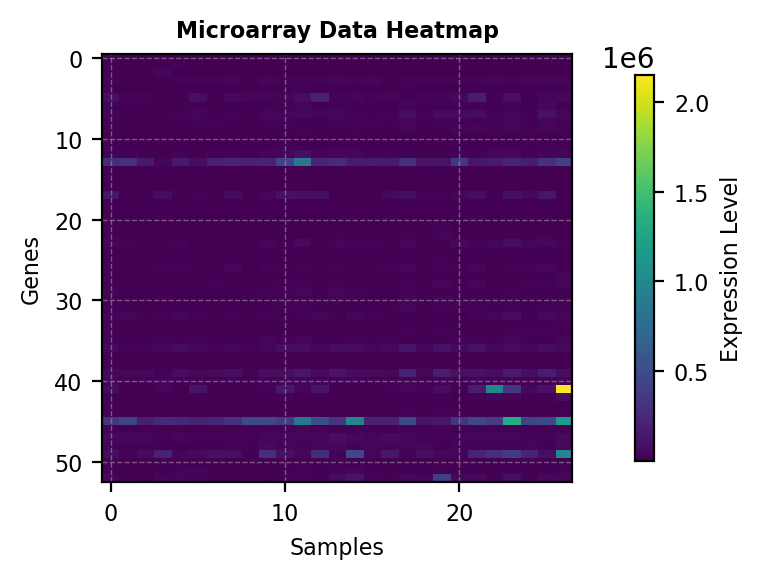

In [1474]:
# Set a larger figure size and high DPI for better resolution
plt.figure(figsize=(4, 3), dpi=200)

# Use 'nearest' interpolation for a sharper image
ind = 0
plt.imshow(data[:,:,ind], aspect='auto', cmap='viridis', interpolation='nearest')

# Add a colorbar with better padding
cbar = plt.colorbar(pad=0.1, shrink=0.9)  # Shrinks the colorbar to 70% of its default size
cbar.set_label("Expression Level", fontsize=8)
cbar.ax.tick_params(labelsize=8)  # Reduce tick label size

# Label axes with larger font size
plt.xlabel("Samples", fontsize=8)
plt.ylabel("Genes", fontsize=8)
plt.title("Microarray Data Heatmap", fontsize=8, fontweight='bold')

# Improve tick visibility
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Add a grid for better readability
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.5)

# Show the figure with tight layout
plt.tight_layout()
plt.show()

In [1495]:
ind = -1
K = 3
Xs = data[:,:,ind].T
Xa = data[:,:,ind]

# Step 1: Normalize the data using StandardScaler
scaler = MinMaxScaler(feature_range=(1, 10))
# scaler = RobustScaler()
# scaler = StandardScaler()
Xa_n = scaler.fit_transform(Xa)
Xs_n = Xa_n.T

model=DA(K,tol=1e-4,max_iter=1000,alpha=1.05,
            purturb=0.01,beta_final=None,verbos=0,normalize=False)
model.fit(Xs,Px='auto')
Ys,Ps = model.cluster()
print(model.return_cost())

!!--normalization without auto weighting on Px--!!
0.7645388174086074


In [1496]:
model.fit(Xs_n,Px='auto')
Ys_n2,Ps_n = model.cluster()
print(model.return_cost())
Ys_n = (scaler.inverse_transform(scaler.inverse_transform(Ys_n2.T))).T

!!--normalization without auto weighting on Px--!!
0.6755881540050146


In [1497]:
# Perform K-Means Clustering
N, d = Xa.shape
kmeans = KMeans(n_clusters=K, n_init=10)
labels = kmeans.fit_predict(Xa_n)
Y_kmeans_2 = kmeans.cluster_centers_
Y_kmeans = scaler.inverse_transform(Y_kmeans_2)
P_kmeans = np.zeros((N, K)) 
P_kmeans[np.arange(N), labels] = 1  # Assign 1s to the corresponding cluster indices

In [1498]:
H = update_P(P_kmeans, Xa, Y_kmeans)

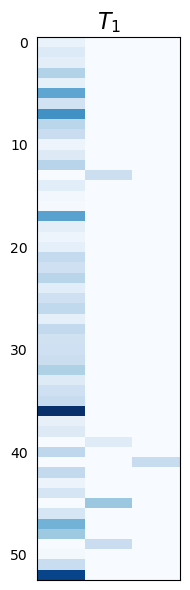

In [1499]:
# Set figure size and aspect ratio
fig, ax = plt.subplots(figsize=(2, 6), dpi=100)  # Adjust width & height

# Display the heatmap
im = ax.imshow(H, cmap="Blues", aspect="auto", interpolation="nearest")

# Remove x-axis labels and ticks
ax.set_xticks([])
ax.set_xticklabels([])
ax.tick_params(left=False)

# Add a title with italic styling
ax.set_title(r"$\mathit{T_1}$", fontsize=16, fontweight='bold', style='italic')

# Adjust layout for tight fit
plt.tight_layout()
plt.show()

In [1500]:
Clustering_Cost(Xs.T, Y_kmeans, P_kmeans) * 1e-9

54.179845053654944

### Alisina's Implementation

In [1501]:
def cluster_beta(X_init,Y_init,m,beta,pert):
    N, d = np.shape(X_init)
    Y_init += pert * (np.arange(m)+1).reshape(-1,1) * np.ones((m,d))
    X_expanded = np.expand_dims(X_init, 1)       # Shape (N, 1, d)
    Y_expanded = np.expand_dims(Y_init, 0)       # Shape (1, m, d)

    # Compute the squared differences, sum over the coordinate axis (axis=2)
    distances = np.sum((X_expanded - Y_expanded) ** 2, axis=2)
    distances_n = distances - np.min(distances, axis = 1).reshape(-1,1)
    P_yx = np.exp(-beta * distances_n)/(np.sum(np.exp(-beta * distances_n),axis = 1).reshape(-1,1))
    P_xy = P_yx/(np.sum(P_yx, axis = 0).reshape(1,-1))
    Y_c = P_xy.T @ X_init
    return Y_c, P_yx, P_xy

def clustering(X_init,m,pert,beta_final,alpha):
    beta = 0.001
    N, d = X_init.shape
    Y_init = np.mean(X_init,axis = 0)*np.ones((m,d))
    while beta <= beta_final:
        Y, P_yx, P_xy = cluster_beta(X_init,Y_init,m,beta,pert)
        beta *= alpha 
        Y_init = Y
        # print('beta: ', beta)
    return Y, P_yx

def Free_Energy(X, Y, q, P_ylx, beta):
    # Computation of the free energy
    N = X.shape[0]
    m = Y.shape[0]
    X_expanded = np.expand_dims(X, 1)       # Shape (N, 1, 2)
    Y_expanded = np.expand_dims(Y, 0)       # Shape (1, m, 2)
    distances = np.sum((X_expanded - Y_expanded) ** 2, axis=2)
    Px = np.diag(q)
    Py = np.sum(Px @ P_ylx, axis = 0)
    F = np.sum(Px @ np.multiply(P_ylx, distances + 1/beta * np.log(P_ylx)))

    return F

def F_Fdot_clustering(X, Y, q, P_ylx, u_y, u_p, u_b, beta):
    # Computation of the free energy
    N = X.shape[0]
    m = Y.shape[0]
    X_expanded = np.expand_dims(X, 1)       # Shape (N, 1, 2)
    Y_expanded = np.expand_dims(Y, 0)       # Shape (1, m, 2)
    distances = np.sum((X_expanded - Y_expanded) ** 2, axis=2)
    Px = np.diag(q)
    Py = np.sum(Px @ P_ylx, axis = 0)
    F = np.sum(Px @ np.multiply(P_ylx, distances + 1/beta * np.log(P_ylx)))
    F_shifted = F + 1/beta * np.log(m)

    # Time derivatives
    ## w.r.t Y: sum_{j=1}^m (dF/dy_j)^T u_j
    dFdY = 2 * (Py[:, np.newaxis] * Y - P_ylx.T @ Px @ X)
    dotF_y = cp.sum(cp.multiply(dFdY,u_y))

    ## w.r.t P_{y|x}: \sum_{i,j} dF/dp_{j|i} v_ij
    dotF_p = cp.sum(cp.multiply(Px @ (distances + 1/beta * np.log(P_ylx) + 1/beta), u_p))

    ## w.r.t beta: (1/beta)^2 H
    dFdb = -1/beta**2 * np.sum(Px @ np.multiply(P_ylx, np.log(P_ylx)))
    dotF_beta = dFdb * u_b

    # Total time derivative
    Fdot = dotF_y + dotF_p + dotF_beta

    return F_shifted, Fdot

def h_hdot(P_ylx, u_p):
    h = P_ylx * (1 - P_ylx)
    hdot = cp.multiply((1 - 2 * P_ylx), u_p)
    return h, hdot

def l_ldot(c, q, P_ylx, u_p):
    l = c - np.dot(q, P_ylx)
    ldot = - (q[:,np.newaxis].T @ u_p).flatten()
    return l, ldot

def control_dyn(X, Y, q, P_ylx, beta, u_b, p, gamma, alpha_h, alpha_l, c):
    
    N, d = X.shape
    m = Y.shape[0]
    # Decision variables 
    u_p = cp.Variable((N,m))
    u_y = cp.Variable((m,d))  
    # u_y = cp.Parameter((m,2))
    # u_y.value = np.zeros((m,2))
    delta = cp.Variable(1)
    
    ## Constant parameters of the QP
    # p = 1000
    # gamma = 1
    # alpha_h = 10
    # alpha_l = 10

    # Objective: minimize the sum of squares of x and the sum of q
    objective = cp.Minimize(cp.sum_squares(u_p) + cp.sum_squares(u_y) + p * delta**2)

    # Define constraints
    F , Fdot = F_Fdot_clustering(X, Y, q, P_ylx, u_y, u_p, u_b, beta)
    h, h_dot = h_hdot(P_ylx, u_p)
    l, l_dot = l_ldot(c, q, P_ylx, u_p)

    constraints = [
        Fdot <= -gamma * F + delta,
        cp.sum(u_p, axis=1) == 0,
        h_dot >= -alpha_h * h,
        l_dot >= -alpha_l * l
    ]

    # Define the problem
    problem = cp.Problem(objective, constraints)

    # Solver Options for OSQP
    solver_options = {
        'max_iter': 50000,         # Increase max iterations to 20000
        'eps_abs': 1e-4,           # Adjust absolute tolerance
        'eps_rel': 1e-4,           # Adjust relative tolerance
        'eps_prim_inf': 1e-3,      # Adjust primal infeasibility tolerance
        'eps_dual_inf': 1e-3,      # Adjust dual infeasibility tolerance
        'verbose': False           # Enable verbose output to track solver progress
    }

    # Solve the problem using OSQP with customized options
    result = problem.solve(solver = 'OSQP', **solver_options)
    
    # Check the results
    if np.isnan(problem.value).any() == True:
        print("Nan encountered!")
        return np.zeros((N,m)), np.zeros((m,d)), F, 0
    else:         
        return u_p.value, u_y.value, F, Fdot.value
    
def project_to_stochastic_matrix(matrix):
    """
    Projects each row of the input matrix onto the simplex (triangle) defined by:
    - The row sums to 1
    - Each element in the row lies within [0, 1]

    :param matrix: np.ndarray, the input matrix (shape: NxM)
    :return: np.ndarray, the projected matrix (same shape as input)
    """
    def project_to_plane(vector):
        N = vector.shape[0]
        normal = np.ones((N,))
        p = 1 / N * np.ones((N,))
        n_dot_n = N
        v_dot_n = np.dot(vector, normal)
        p_dot_n = np.dot(p, normal)
        projection = vector - ((v_dot_n - p_dot_n) / n_dot_n) * normal
        return projection

    def project_to_triangle(v):
        tol = 1e-7
        v_proj = project_to_plane(v)
        v_clamped = np.clip(v_proj, tol, 1 - tol)
        sum_clamped = np.sum(v_clamped)

        if sum_clamped == 1:
            return v_clamped
        elif sum_clamped < 1:
            deficit = 1 - sum_clamped
            free_indices = v_clamped < 1
            num_free = np.sum(free_indices)
            if num_free > 0:
                increment = deficit / num_free
                v_clamped[free_indices] += increment
            return v_clamped
        else:
            return v_clamped / sum_clamped

    # Apply the projection to each row of the matrix
    projected_matrix = np.apply_along_axis(project_to_triangle, axis=1, arr=matrix)
    return projected_matrix

def dynamics_v2(z, X, beta, q, p, gamma, alpha_h, alpha_l, c, N, m):
    """
    Computes the time derivative of the state.
    
    Parameters:
      t       : time (not used explicitly here, but required by solve_ivp)
      z       : flattened state vector [Y.flatten(), P.flatten(), beta]
      X       : initial parameter or state used in control_dyn
      q, u_b, p, gamma, alpha_h, alpha_l : additional parameters for control_dyn
      N       : mumber of data poits
      m       : number of facilities
      
    Returns:
      dz/dt  : flattened derivative vector.
    """
    # Unpack the state vector
    d = X.shape[1]
    n_Y = m * d
    n_P = N * m
    Y = z[0:n_Y].reshape(m,d)
    P = z[n_Y:n_Y+n_P].reshape(N,m)
    u_b = 0
    

    # Compute control inputs; control_dyn should return u_p and u_y for state evolution.
    u_p, u_y, F_b, Fdot_b = control_dyn(X, Y, q, P, beta, u_b, p, gamma, alpha_h, alpha_l, c)
    
    # Compute the derivatives
    dY_dt = u_y           # dY/dt = u_y
    dP_dt = u_p           # dP/dt = u_p
    
    # Flatten the derivatives into a single vector
    dzdt = np.concatenate([dY_dt.flatten(), dP_dt.flatten()])
    return dzdt, F_b, Fdot_b

def adaptive_euler_forward(dynamics, z0, X, beta, q, p, gamma, alpha_h, alpha_l, c, N, m, T_f, dt_init=0.01, dt_min=1e-4, dt_max=0.1, tol=1e-2):
    """
    Adaptive Euler integration with projection step for P based on Adaptive Gradient Descent.
    Includes modifications to prevent step size shrinking.

    Parameters:
      dynamics : function returning dz/dt
      z0       : initial state
      T_f      : final time
      dt_init  : initial step size (lambda_0 in algorithm)
      dt_min   : minimum allowable step size
      dt_max   : maximum allowable step size
      tol      : stopping criterion for abs(Fdot)
      
    Returns:
      z : final state after integration
    """
    
    # Initialization
    np.random.seed(2)
    d = (len(z0) - N * m)//m
    z_prev = z0
    dt_prev = dt_init  # lambda_0
    theta_prev = np.inf  # theta_0 = +inf
    t = 0.0
    iter_count = 0
    pert = 1e-10

    while t < T_f:
        # Compute gradient step
        dzdt, F, Fdot = dynamics(z_prev, X, beta, q, p, gamma, alpha_h, alpha_l, c, N, m)

        # Termination condition if |Fdot| is too small
        if abs(Fdot) < tol:
            print(f"Terminating early at iteration {iter_count}, time {t} because abs(Fdot)={abs(Fdot):.6f} < tol={tol}")
            break

        # Compute new step size (lambda_k)
        if iter_count > 0:
            step_size_1 = np.sqrt(1 + theta_prev) * dt_prev
            grad_diff = np.linalg.norm(dzdt - dzdt_old) + 1e-6  # Regularization term to prevent division by zero
            step_size_2 = np.linalg.norm(z_prev - z_old) / (2 * grad_diff)  

            dt = min(max(step_size_1, dt_min), dt_max)  # Keep dt in range [dt_min, dt_max]
        else:
            dt = dt_init  # First iteration uses initial step size

        # Euler update
        z_next = z_prev + dt * dzdt

        # Projection step for P
        n_Y = m * d
        n_P = N * m
        Y_next = z_next[:n_Y].reshape(m, d) + pert * np.random.rand(m,d)
        P_next = z_next[n_Y:].reshape(N, m)

        # Apply projection to P
        P_projected = project_to_stochastic_matrix(P_next)

        # Reassemble state with projected P
        z_projected = np.concatenate([Y_next.flatten(), P_projected.flatten()])

        # Compute new theta_k
        if iter_count > 0:
            theta = dt / dt_prev
        else:
            theta = 1.0  # Initial theta value

        # Update variables for next iteration
        z_old = z_prev
        dzdt_old = dzdt
        dt_prev = dt
        theta_prev = theta
        z_prev = z_projected
        t += dt
        iter_count += 1

    return z_prev


def closest_binary_matrix(P):
    """
    Converts a row-stochastic matrix P into its closest binary matrix.
    
    Parameters:
    P (numpy.ndarray): A (N, K) row-stochastic matrix where rows sum to 1.
    
    Returns:
    numpy.ndarray: A (N, K) binary matrix with one 1 per row.
    """
    binary_matrix = np.zeros_like(P)  # Initialize a binary matrix with zeros
    max_indices = np.argmax(P, axis=1)  # Get the index of the max element in each row
    binary_matrix[np.arange(P.shape[0]), max_indices] = 1  # Set the max index to 1
    
    return binary_matrix

def get_permutation_matrix(A):
    """
    Returns the permutation matrix that sorts the columns of A in descending order of column sums.

    Parameters:
    A (numpy.ndarray): The matrix whose column sums determine the permutation.

    Returns:
    P (numpy.ndarray): The permutation matrix.
    """
    # Compute column sums
    col_sums = np.sum(A, axis=0)

    # Get column order indices (sorted in descending order)
    sorted_indices = np.argsort(-col_sums)  # Negative sign for descending order

    # Create the permutation matrix
    P = np.eye(A.shape[1])[:, sorted_indices]

    return P

def solve_constrained_clustering(Xa_n, m, C, pert=1e-6, beta_init=0.001, beta_final=50, beta_factor=1.5):
    """
    Solves the constrained clustering problem for a given normalized dataset Xa_n.

    Parameters:
    - Xa_n (numpy.ndarray): Normalized data matrix of shape (N, d).
    - m (int): Number of clusters.
    - pert (float): Perturbation level for initialization.
    - beta_final (float): Final beta value.
    - alpha (float): Clustering parameter.

    Returns:
    - Ya_n_c (numpy.ndarray): Cluster centers (in normalized space).
    - Pa_n_c_bin (numpy.ndarray): Binary assignment matrix.
    - Pi (numpy.ndarray): Permutation matrix.
    - D_constrained (float): Clustering cost.
    - H_constrained (numpy.ndarray): H matrix.
    - Py_constrained (numpy.ndarray): Assignment vector.
    """

    N, d = Xa_n.shape  # Extract dimensions

    # Step 1: Initialize Y and P
    Y0 = np.mean(Xa_n, axis=0) * np.ones((m, d)) + pert * np.random.rand(m, d)
    P0 = np.random.rand(N, m)
    P0 = P0 / P0.sum(axis=1, keepdims=True)

    q = 1 / N * np.ones(N)
    Px = np.diag(q)
    Py = np.sum(Px @ P0, axis=0)
    z0_init = np.concatenate([Y0.flatten(), P0.flatten()])
    z0 = np.copy(z0_init)  # Ensure z0 is not modified in-place

    # Step 2: Set up parameters for constrained clustering
    alpha_h = 40
    alpha_l = 20
    p = 10
    gamma = 1

    # Estimate maximum iterations
    max_iterations = int(np.ceil(np.log(beta_final / beta_init) / np.log(beta_factor))) + 1

    # Preallocate storage
    z_values = np.zeros((max_iterations, z0.shape[0]))
    beta_values = np.zeros(max_iterations)

    # Store initial values
    z_values[0, :] = z0_init
    beta_values[0] = beta_init

    # Iteratively solve for constrained clustering
    beta = beta_init
    counter = 1
    c = C * np.ones(m)

    while beta < beta_final:
        print(f"Iteration {counter}: Solving for beta = {beta}")

        # Solve constrained optimization using Euler forward integration
        z = adaptive_euler_forward(
            dynamics_v2, z0, Xa_n, beta, q, p, gamma, alpha_h, alpha_l, c, N, m,
            T_f=15, dt_init=0.01, dt_min=1e-4, dt_max=0.1, tol=1e-2
        )
        
        # Store results
        beta_values[counter] = beta
        z_values[counter, :] = z  # Store z in preallocated array

        # Increase beta geometrically
        beta *= beta_factor

        # Update initial z for the next iteration
        z0 = np.copy(z)

        counter += 1

    # Trim storage arrays
    beta_values = beta_values[:counter]
    z_values = z_values[:counter, :]

    # Extract final clustering results
    n_Y = m * d
    n_P = N * m
    Ya_n_c_2 = z_values[-1, :n_Y].reshape(m, -1)  # Cluster centers
    Pa_n_c = z_values[-1, n_Y:].reshape(N, m)  # Assignment matrix

    # Convert assignment matrix to binary
    Pa_n_c_bin = closest_binary_matrix(Pa_n_c)

    # Compute permutation matrix
    Pi = get_permutation_matrix(Pa_n_c_bin)

    return Pi.T @ Ya_n_c_2, Pa_n_c_bin @ Pi

In [1502]:
pert = 10e-10
m = 3
beta_final = 50
alpha = 1.2
Ya, Pa = clustering(Xa,m,pert,beta_final,alpha)
Ya_n2, Pa_n = clustering(Xa_n,m,pert,beta_final,alpha)
Ya_n = scaler.inverse_transform(Ya_n2)

In [1503]:
H = update_P(Pa_n, Xa, Ya_n)

In [1504]:
Clustering_Cost(Xa, Ya_n, Pa_n) * 1e-9

450.8357686995887

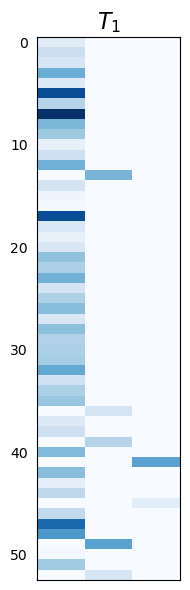

In [1507]:
# Set figure size and aspect ratio
fig, ax = plt.subplots(figsize=(2, 6), dpi=100)  # Adjust width & height

# Display the heatmap
im = ax.imshow(H, cmap="Blues", aspect="auto", interpolation="nearest")

# Remove x-axis labels and ticks
ax.set_xticks([])
ax.set_xticklabels([])
ax.tick_params(left=False)

# Add a title with italic styling
ax.set_title(r"$\mathit{T_1}$", fontsize=16, fontweight='bold', style='italic')

# Adjust layout for tight fit
plt.tight_layout()
plt.show()

### Capacity Constrained

In [1506]:
Ya_n_c_2, Pa_n_c_bin = solve_constrained_clustering(Xa_n, m=3, C=0.35, beta_init=0.001, beta_factor=1.2)
# Transform cluster centers back to original scale
Ya_n_c = Ya_n_c_2
# Ya_n_c = scaler.inverse_transform(Ya_n_c_2)

Iteration 1: Solving for beta = 0.001
Iteration 2: Solving for beta = 0.0012
Iteration 3: Solving for beta = 0.0014399999999999999
Iteration 4: Solving for beta = 0.0017279999999999997
Iteration 5: Solving for beta = 0.0020735999999999997
Iteration 6: Solving for beta = 0.0024883199999999996
Iteration 7: Solving for beta = 0.0029859839999999993
Iteration 8: Solving for beta = 0.003583180799999999
Iteration 9: Solving for beta = 0.0042998169599999985
Iteration 10: Solving for beta = 0.005159780351999998
Iteration 11: Solving for beta = 0.0061917364223999976
Iteration 12: Solving for beta = 0.007430083706879997
Iteration 13: Solving for beta = 0.008916100448255996
Iteration 14: Solving for beta = 0.010699320537907194
Iteration 15: Solving for beta = 0.012839184645488633
Iteration 16: Solving for beta = 0.01540702157458636
Iteration 17: Solving for beta = 0.01848842588950363
Iteration 18: Solving for beta = 0.022186111067404354
Iteration 19: Solving for beta = 0.026623333280885224
Iterati

In [1508]:
H = update_P(Pa_n_c_bin, Xa, Ya_n_c)

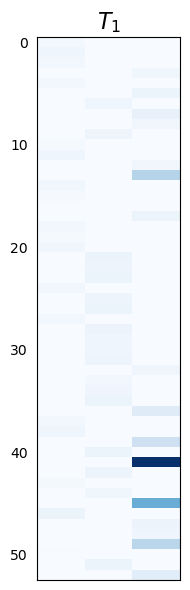

In [1509]:
# Set figure size and aspect ratio
fig, ax = plt.subplots(figsize=(2, 6), dpi=100)  # Adjust width & height

# Display the heatmap
im = ax.imshow(H, cmap="Blues", aspect="auto", interpolation="nearest")

# Remove x-axis labels and ticks
ax.set_xticks([])
ax.set_xticklabels([])
ax.tick_params(left=False)

# Add a title with italic styling
ax.set_title(r"$\mathit{T_1}$", fontsize=16, fontweight='bold', style='italic')

# Adjust layout for tight fit
plt.tight_layout()
plt.show()

In [1510]:
Clustering_Cost(Xa, Ya_n_c, Pa_n_c_bin) * 1e-9

1219.6604689202763

In [1511]:
np.sum(Pa_n_c_bin/N, axis=0)

array([0.35849057, 0.33962264, 0.30188679])

### Final Simulation Results

In [1512]:
# Given parameters
pert = 1e-10
m = 3
beta_final = 50
alpha = 1.2

# Assume `data` is the (53, 27, 7) matrix provided
N, K, T = data.shape  # Extract dimensions

# Initialize storage
clustering_costs = []  # Store costs for each time instance
H_matrices = []        # Store H matrices for each time instance
Py_list = []           # Store the list of assigment arrays

# Iterate over each time instance
for find in range(T):
    Xa = data[:, :, find]  # Extract data matrix at time 'find'
    Xa_n = scaler.fit_transform(Xa)

    # Step 1: Perform clustering (unconstrained)
    Ya_2, Pa = clustering(Xa_n, m, pert, beta_final, alpha)
    Ya = scaler.inverse_transform(Ya_2)   # Convert back to original scale
    # Ya = Ya_2
    Pa_bin = closest_binary_matrix(Pa)

    # Step 2: Compute clustering cost
    D = Clustering_Cost(Xa, Ya, Pa_bin) * 1e-9
    clustering_costs.append(D)  # Store the cost

    # Step 3: Compute permutation matrix and rearrange Pa and Ya
    Pi = get_permutation_matrix(Pa_bin)
    Pa_bin, Ya = Pa_bin @ Pi, Pi.T @ Ya

    # Step 4: Compute H matrix
    H = H = update_P(Pa_bin, Xa, Ya)
    H_matrices.append(H)  # Store H matrix

    # Step 5: Compute assignment vecors
    Py = np.sum(Pa_bin/N, axis = 0)
    Py_list.append(Py)

# Convert lists to numpy arrays for easy indexing
clustering_costs = np.array(clustering_costs)
H_matrices = np.array(H_matrices)
Py_array = np.array(Py_list)

# Print results
print("Clustering Costs for Each Time Step:\n", clustering_costs)
print("Shape of Stored H Matrices:", H_matrices.shape)  
print("Shape of Stored Py Vectors:", Py_array.shape)  


Clustering Costs for Each Time Step:
 [ 134.31976804  110.33502346   72.87206685   99.00821496 1092.36196282
 1833.30787526  450.8357687 ]
Shape of Stored H Matrices: (7, 53, 3)
Shape of Stored Py Vectors: (7, 3)


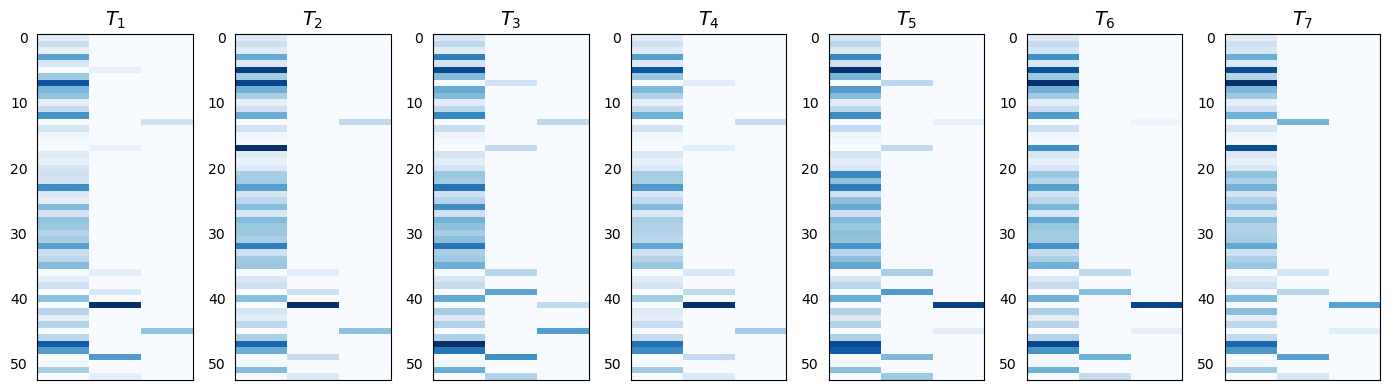

In [1513]:
# Set up 1x7 subplots
fig, axes = plt.subplots(1, 7, figsize=(14, 4), dpi=100)

# Iterate through each H matrix and plot it
for i in range(7):
    ax = axes[i]
    im = ax.imshow(H_matrices[i], cmap="Blues", aspect="auto", interpolation="nearest")

    # Remove x-axis labels and ticks
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.tick_params(left=False)

    # Add title for each subplot (T1, T2, ..., T7)
    ax.set_title(r"$\mathit{T_" + str(i+1) + "}$", fontsize=14, fontweight='bold', style='italic')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Iteration 1: Solving for beta = 0.001
Iteration 2: Solving for beta = 0.0012
Iteration 3: Solving for beta = 0.0014399999999999999
Iteration 4: Solving for beta = 0.0017279999999999997
Iteration 5: Solving for beta = 0.0020735999999999997
Iteration 6: Solving for beta = 0.0024883199999999996
Iteration 7: Solving for beta = 0.0029859839999999993
Iteration 8: Solving for beta = 0.003583180799999999
Iteration 9: Solving for beta = 0.0042998169599999985
Iteration 10: Solving for beta = 0.005159780351999998
Iteration 11: Solving for beta = 0.0061917364223999976
Iteration 12: Solving for beta = 0.007430083706879997
Iteration 13: Solving for beta = 0.008916100448255996
Iteration 14: Solving for beta = 0.010699320537907194
Iteration 15: Solving for beta = 0.012839184645488633
Iteration 16: Solving for beta = 0.01540702157458636
Iteration 17: Solving for beta = 0.01848842588950363
Iteration 18: Solving for beta = 0.022186111067404354
Iteration 19: Solving for beta = 0.026623333280885224
Iterati

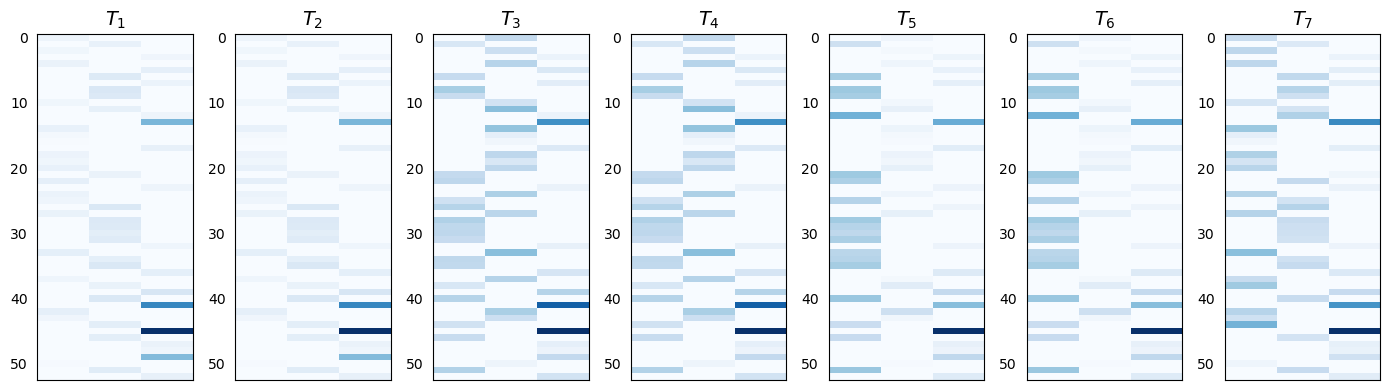

In [1514]:
np.random.seed(42)

# Assume `data` is the (53, 27, 7) matrix provided
N, K, T = data.shape  # Extract dimensions

# Initialize storage
clustering_costs_constrained = []  # Store constrained clustering costs
H_matrices_constrained = []        # Store H matrices for constrained case
Py_list_constrained = []           # Store assignment vectors

# Iterate over each time instance
for find in range(T):
    Xa = data[:, :, find]  # Extract data matrix at time 'find'
    Xa_n = scaler.fit_transform(Xa)

    # Step 1: Solve constrained clustering
    Ya_c_2, Pa_c = solve_constrained_clustering(Xa_n, m=3, C=0.35, beta_factor=1.2)
    Ya_c = scaler.inverse_transform(Ya_c_2)
    Pa_c_bin = closest_binary_matrix(Pa_c)
    
    # Step 2: Compute clustering cost
    D = Clustering_Cost(Xa, Ya_c, Pa_c_bin) * 1e-9
    clustering_costs_constrained.append(D)  # Store the cost

    # Step 4: Compute H matrix
    H = update_P(Pa_c_bin, Xa, Ya_c)
    H_matrices_constrained.append(H)  # Store H matrix

    # Step 5: Compute assignment vecors
    Py = np.sum(Pa_c_bin/N, axis = 0)
    Py_list_constrained.append(Py)

    # Store results
    clustering_costs_constrained.append(D)
    H_matrices_constrained.append(H)
    Py_list_constrained.append(Py)

# Convert lists to numpy arrays
clustering_costs_constrained = np.array(clustering_costs_constrained)
H_matrices_constrained = np.array(H_matrices_constrained)
Py_array_constrained = np.array(Py_list_constrained)

# Print results
print("Constrained Clustering Costs for Each Time Step:\n", clustering_costs_constrained)
print("Shape of Stored Constrained H Matrices:", H_matrices_constrained.shape)  
print("Shape of Stored Constrained Py Vectors:", Py_array_constrained.shape)

# Plot all constrained H matrices in a 1x7 subplot layout
fig, axes = plt.subplots(1, 7, figsize=(14, 4), dpi=100)

for i in range(7):
    ax = axes[i]
    im = ax.imshow(H_matrices_constrained[i], cmap="Blues", aspect="auto", interpolation="nearest")

    # Remove x-axis labels and ticks
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.tick_params(left=False)

    # Add title for each subplot
    ax.set_title(r"$\mathit{T_" + str(i+1) + "}$", fontsize=14, fontweight='bold', style='italic')

plt.tight_layout()
plt.show()

In [1515]:
Py_array_constrained

array([[0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679],
       [0.35849057, 0.33962264, 0.30188679]])